# Libraries

In [1]:
import os
import random
from dataclasses import dataclass

from tqdm import tqdm

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from diffusers import UNet2DModel
from torchvision.models import resnet50, ResNet50_Weights
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator

from datasets import load_dataset

from matplotlib import pyplot as plt

from add.diffusion import forward_diffusion_process, backward_diffusion_process
from add.loops import train_epoch, sample_images_cfg, sample_images
from add.utils import add_zero_class, seed_everything, show_images, make_grid

# Config

In [2]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    batch_size = 32
    num_epochs = 100
    gradient_accumulation_steps = 8
    student_learning_rate = 3e-5
    discriminator_learning_rate = 3e-4
    lr_warmup_steps = 500

    num_student_steps = 4
    num_student_steps = 100
    
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    device = "cuda"
    random_state = 42 


config = TrainingConfig()

In [3]:
seed_everything(config.random_state)

# Utils

In [ ]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

# Data

In [5]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("food101", split='train')

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images, "label": examples["label"]}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config.batch_size, shuffle=True
)

# Model, Samplers, Optimizers, Schedulers

In [15]:
T = torch.load("food101_conditional_ddpm/model_79.pt")
S = torch.load("food101_conditional_ddpm/model_79.pt")
D = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
D.fc = nn.Linear(2048, 2)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

# S_noise_scheduler = DDPMScheduler(
#     num_train_timesteps=4, 
#     beta_schedule="linear",
#     beta_start=0.0001,
#     beta_end=1.0
# )
# S_noise_scheduler.set_timesteps(num_inference_steps=4)

S_optimizer = torch.optim.AdamW(S.parameters(), lr=config.student_learning_rate)
D_optimizer = torch.optim.AdamW(D.parameters(), lr=config.discriminator_learning_rate)

S_scheduler = get_cosine_schedule_with_warmup(
    optimizer=S_optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

D_scheduler = get_cosine_schedule_with_warmup(
    optimizer=D_optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Noisy X shape torch.Size([8, 3, 128, 128])


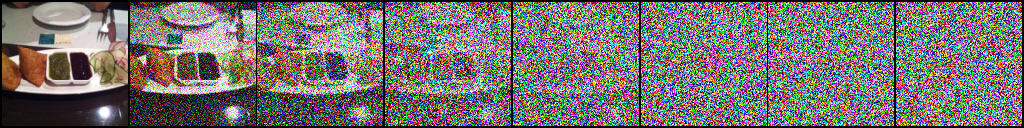

In [16]:
x = next(iter(train_dataloader))["images"][:1].repeat(8, 1, 1, 1)
timesteps = torch.linspace(0, 999, 8).long()
noise = torch.randn_like(x)
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
print("Noisy X shape", noisy_x.shape)
show_images(noisy_x).resize((8 * 128, 128), resample=Image.NEAREST)

# How does our pretrained model perform on 4 steps?

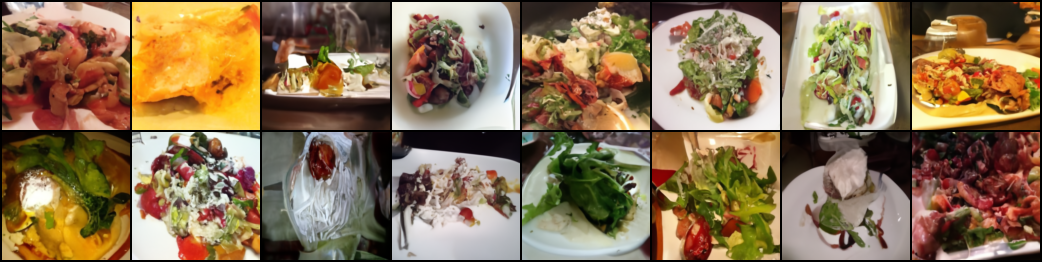

In [10]:
sampled_images = sample_images(
    model=T, 
    noise_scheduler=noise_scheduler, 
    device=config.device, 
    c=6,
    num_inference_steps=100,
)

show_images(sampled_images)

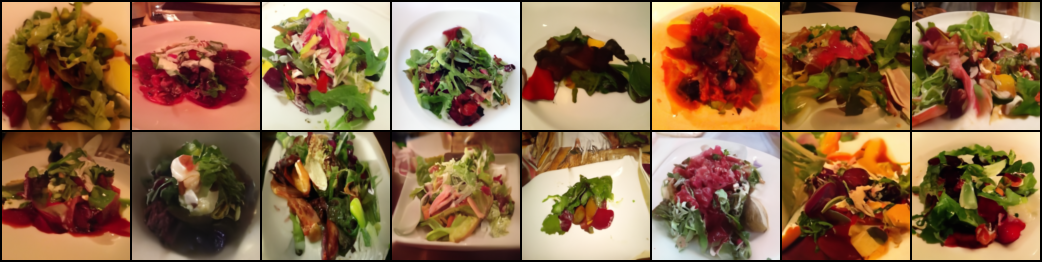

In [11]:
sampled_images = sample_images_cfg(
    model=T, 
    noise_scheduler=noise_scheduler, 
    device=config.device, 
    c=6,
    num_inference_steps=100,
)

show_images(sampled_images)

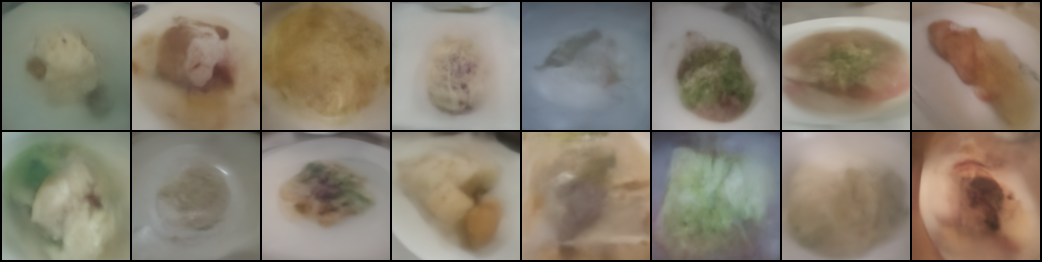

In [12]:
sampled_images = sample_images(
    model=S, 
    noise_scheduler=noise_scheduler, 
    device=config.device, 
    c=6,
    num_inference_steps=4,
)

show_images(sampled_images)

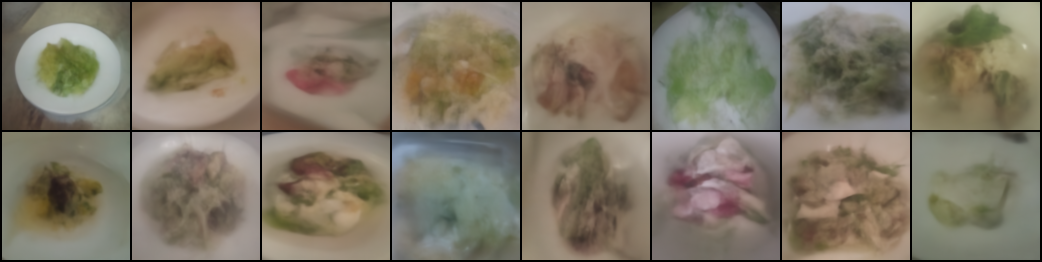

In [13]:
sampled_images = sample_images_cfg(
    model=S, 
    noise_scheduler=noise_scheduler, 
    device=config.device, 
    c=6,
    num_inference_steps=4,
)

show_images(sampled_images)

# Prepair or model for Accelerate trainig

In [14]:
from accelerate import Accelerator

accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps, 
)

train_dataloader, S, T, D, S_optimizer, D_optimizer = accelerator.prepare(
    train_dataloader, S, T, D, S_optimizer, D_optimizer
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
for epoch in range(100):
    S_loss, D_loss = train_epoch(S, T, D, 
                S_optimizer, D_optimizer, 
                accelerator=accelerator, 
                adversarial_loss=nn.CrossEntropyLoss().to(config.device), 
                reconstruction_loss=nn.MSELoss().to(config.device), 
                lambd=2.5,
                dataloader=train_dataloader, 
                device=config.device,
                num_student_timesteps=4,
                num_teacher_timesteps=1,
               )

    if (epoch + 1) % 5 == 0:
        generated_images = eval_epoch(S, S_noise_scheduler, config.device, num_inference_steps=4)
        print(generated_images)
        pil_images = show_images(generated_images)
        plt.imshow(pil_images)
        pil_images.save(f"{epoch}.jpg")

        torch.save(S, f"celeba_unconditional_add/S_{epoch}.pt")
        torch.save(D, f"celeba_unconditional_add/D_{epoch}.pt")

  0%|▏                                                                                       | 4/2368 [00:30<6:07:57,  9.34s/it]